In [ ]:
# default_exp diffusion_flow_embedding
from nbdev.showdoc import *
import numpy as np
%load_ext autoreload
%autoreload 2

In [ ]:
# export
# hide
import torch
import torch.nn as nn

# Flow Embedding with Diffusion

The first generation of the flow embedding network was based around the preservation of distances in the embedding space. It's now obvious that this was the wrong tact. Caring about distance preservation puts most emphasis on far away points (including pathological cases, when there's no connectivity and the distance is "infinite"). 

Affinities do the trick here much better. They naturally emphasize only local distances, and allow the network to heavily discount (if not outright ignore) long-range connectivity. 

This locality creates a new model of flow. Previously, our network used euclidean lines between points, and used the flow only to determine the length of each line. Going against (and especially, going perpendicular) to the flow was *possible*, just not easy.

With the diffusion-based model, we think in terms of probabilities, rather than distances. 
This has a couple of downstream effects:
- Going with the flow is *highly* encouraged. Going against or even perpendicular is given (depending on the kernel function used) a probability close to zero.
- Points travel on *paths* dictated by the flow. The likelihood of reaching point $i$ from $j$ is governed not by the *shortest* path, but the aggregate of all paths, weighted by probability. This has the dual effects of diminishing the effect of outliers, and providing an intuitive model of motion. You don't have to reason about which path is "lowest energy", just which path is most likely based on the directions of flow.

## The Pieces of the Algorithm

We compute the probabilities of transition between the points with three steps:
1. Learn a "Flow Artist": a neural network to learn flow over the euclidean field.
  - This is currently a function of two variables $F(x,y): \mathbb{R}^2 \to \mathbb{R}$. The direction of flow is the negative gradient $-\Delta F$.
2. Compute the probabilities of transition between the grid points and the embeddings of points.
3. Compute the probabilities of transition from grid points to grid points.

The probability of transitioning from one point to another is then the amalgam of these steps: we transition to the grid, transition within the grid for $t$ steps, and then transition back to a point. Each probability gives a matrix.

## Probability Kernel from Flow

The foundation of these is the conversion from *flow* (the vector field) to probabilities of transition. This is done using a kernel based on the degree of divergence between the direction specified and the flow, as below, where $r$ is the flow direction (a vector) and $v$ is the direction of the edge.
$$ e^{-(\|r\|^2 - r \cdot v)/\sigma} $$
When the flow is aligned with the direction, this returns 1. When it is perpendicular, $e^{-\|r\|^2/\sigma}$, and when against the flow, $e^{-2\|r\|^2/\sigma}$.

We should tune $\sigma$ to ensure that a 45 degree angle returns a quantity significantly above zero.

We'll create a function that performs this operation on batches of flows and directions. The input will be an array of flows (e.g. the flow per point), and a batch of directions (e.g. NESW for each point). It will, of course, use PyTorch for backpropogation capable operations

In [ ]:
#export
def affinity_from_flow(flows, directions_array, flow_strength = 1, sigma=1):
  """Compute probabilities of transition in the given directions based on the flow. 

  Parameters
  ----------
  flows : torch tensor of shape n_points x n_dims
      _description_
  directions_array : torch tensor of shape n_directions x n_points x n_dims. Assumed to be normalized.
      _description_
  sigma : int, optional
      kernel bandwidth, by default 1
  returns (n_points)
  """
  assert len(flows.shape) == 2 # flows should only have one dimension
  assert len(directions_array.shape) > 1 and len(directions_array.shape) < 4
  n_directions = directions_array.shape[0]
  # Normalize directions
  length_of_directions = torch.linalg.norm(directions_array,dim=-1)
  normed_directions = directions_array / length_of_directions[:,:,None]
  # and normalize flows # TODO: Perhaps reconsider
  flows = flows / torch.linalg.norm(flows,dim=1)[:,None]
  
  if len(directions_array) == 1: # convert to 2d array if necessary
    directions_array = directions_array[:,None] 
  # compute dot products as matrix multiplication
  dot_products = (normed_directions * flows).sum(-1)
  # take distance between flow projected onto direction and the direction
  distance_from_flow = (torch.linalg.norm(flows,dim=1)**2).repeat(n_directions,1) - dot_products
  # take absolute value
  distance_from_flow = torch.abs(distance_from_flow)
  print('shape of dff',distance_from_flow.shape)
  # add to this the length of each direction
  distance_from_flow = flow_strength*distance_from_flow + length_of_directions
  # put the points on rows, directions in columns
  distance_from_flow = distance_from_flow.T
  # take kernel of distances
  kernel =  torch.exp(-distance_from_flow/sigma)
  # normalize kernel
  # kernel /= torch.sum(kernel,axis=1)
  return kernel
  
  

### A Sample Computation

In [ ]:
flows = torch.rand(4,2) # Flows for each of 4 points
directions_array = torch.rand(7,4,2) # 7 directions, for each of the four points

In [ ]:
normed_directions = directions_array / torch.linalg.norm(directions_array,dim=-1)[:,:,None]

In [ ]:
normed_directions.shape

torch.Size([7, 4, 2])

In [ ]:
np.linalg.norm(normed_directions,axis=-1)

array([[1.        , 1.        , 1.        , 1.        ],
       [1.        , 0.99999994, 1.        , 1.        ],
       [1.        , 1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        , 1.        ],
       [0.99999994, 1.        , 0.99999994, 0.99999994],
       [1.        , 1.        , 0.99999994, 0.99999994],
       [1.        , 1.        , 1.        , 0.99999994]], dtype=float32)

Next, take a dot product between the directions and the flow, to get a strength of flow at each point in each direction

In [ ]:
dot_products = (directions_array * flows).sum(-1)
dot_products.shape

torch.Size([7, 4])

Convert these dot products into distances by subtracting the norm squared of the flows from the dot product with the flow. If exactly with the flow, we get zero.

In [ ]:
distance_from_flow = (torch.linalg.norm(flows,dim=1)**2).repeat(7,1) - dot_products
distance_from_flow

tensor([[ 0.5265,  0.0957,  0.4081, -0.0905],
        [ 0.5300,  0.1747,  0.4461,  0.1284],
        [-0.1705,  0.4998,  0.1708,  0.1747],
        [ 0.0868,  0.2713,  0.0390,  0.0741],
        [ 0.4554,  0.3263,  0.5404, -0.1924],
        [ 0.4561,  0.0290,  0.1058, -0.1047],
        [ 0.4764,  0.0025,  0.7617, -0.0967]])

### Testing

To ensure this is working as expected, we'll try computations on a single sample point, with flow going in direction (1,1). We'll compare this with six directions: one with, one against, and the rest in the shape of a grid.

In [ ]:
flow = torch.tensor([[1,1]]).float()
directions = torch.tensor([
  [[0.7,0.7]],
  [[0,1]],
  [[1,0]],
  [[0,-1]],
  [[-1,0]],
  [[-0.7,-0.7]]
]).float()
probs = affinity_from_flow(flow,directions,sigma=0.5)

shape of dff torch.Size([6, 1])


In [ ]:
probs

tensor([[0.1381, 0.0753, 0.0753, 0.0045, 0.0045, 0.0025]])

If this went according to plan, the direction with the flow should have probability 1, and the one against should have probability near zero.

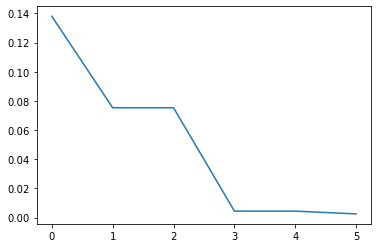

In [ ]:
import matplotlib.pyplot as plt
plt.plot(probs[0])

$\sigma=0.5$ works well here. In particular, the 45 degree angles have fairly high probability, while still being less than the probability of going straight.

This should look like a 3-dimensional pacman

In [ ]:
flow = torch.tensor([[1,1]]).float()
x, y = np.meshgrid(np.linspace(-5,5,20),np.linspace(-5,5,20))
x = torch.tensor(x,dtype=float).cpu()
y = torch.tensor(y,dtype=float).cpu()
xy_t = torch.concat([x[:,:,None],y[:,:,None]],dim=2).float()

In [ ]:
directions_array = xy_t.reshape(400,1,2)
flows = affinity_from_flow(flow, directions_array,flow_strength=2)

shape of dff torch.Size([400, 1])


In [ ]:
length_of_directions = torch.linalg.norm(directions_array,dim=-1)
normed_directions = directions_array / length_of_directions[:,:,None]

In [ ]:
normed_directions.shape

torch.Size([400, 1, 2])

In [ ]:
flows = flows.reshape(20,20)

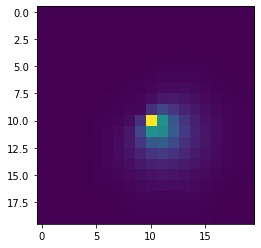

In [ ]:
plt.imshow(flows)

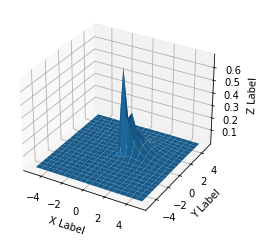

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(x,y,flows)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

In [ ]:
torch.max(flows)

tensor(0.6892)

In [ ]:
X = np.column_stack([x.reshape(400),y.reshape(400),flows.reshape(400)*4])

In [ ]:
from directed_graphs.utils import plot_3d
plot_3d(X,distribution=flows.reshape(400),use_plotly=True)

## Computing Transition Probabilities Between a Grid and Points, and Vice Versa

The next functions will take three inputs: a set of points, a grid, and flows at each point and each point on the grid. It is tasked with returning three matrices: a transition matrix between the points and the grid, a transition matrix between the grid and the points, and the transition matrix from the grid to the grid.

These tasks should be separated, as each is called in different circumstances.
- The grid-to-point (and vv) function will be called each time the points are moved, or the grid is updated, or the flow is updated.
- The grid-to-grid function will be called whenever the grid is updated, or the flow is updated.

Both can be encapsulated in the same function, which computes an affinity matrix from pointset 1 to pointset 2.

The logic of the functions: 
1. For each point in set 1, sort the points in set 2 by distance.
2. Choose the $n$ nearest neighbors (optional computational boost), and compute the transition probabilities to them, storing the results in the affinity matrix.

In [ ]:
#export
def affinity_matrix_from_pointset_to_pointset(pointset1, pointset2, flows,n_neighbors=None,sigma=0.5):
  """Compute affinity matrix between the points of pointset1 and pointset2, using the provided flow.

  Parameters
  ----------
  pointset1 : torch tensor, n1 x d
      The first pointset, to calculate affinities *from*
  pointset2 : torch tensor, n2 x d
      The second pointset, to calculate affinities *to* (from pointset1)
  flow : a function that, when called at a point, gives the flow at that point
  n_neighbors : number of neighbors to include in affinity computations. All neighbors beyond it are given affinity zero
  (currently not implemented)

  Returns:
  Affinity matrix: torch tensor of shape n1 x n2
  """
  # Calculate the directions from point i in pointset 1 to point j in pointset 2
  n1 = pointset1.shape[0]
  n2 = pointset2.shape[0]
  P2 = pointset2[:,:,None].repeat(1,1,n1)
  P1 = pointset1.T.repeat(n2,1,1)
  P3 = (P2 - P1)
  P3 = P3.transpose(1,2)
  # compute affinities from flows and directions
  affinities = affinity_from_flow(flows,P3,sigma=sigma)
  return affinities


### Building the function

This is an illustration of how the function should work.

In [ ]:
pointset1 = torch.rand(4,2)
pointset2 = torch.rand(7,2)
def flow(x):
  return x**2/torch.linalg.norm(x**2)

In [ ]:
pointset1

tensor([[0.4085, 0.5223],
        [0.4046, 0.2863],
        [0.5993, 0.2879],
        [0.4726, 0.7379]])

In [ ]:
pointset2

tensor([[0.2435, 0.1213],
        [0.7581, 0.8408],
        [0.6380, 0.9607],
        [0.4217, 0.5043],
        [0.4438, 0.2772],
        [0.1088, 0.3275],
        [0.3015, 0.4619]])

In [ ]:
pointset2[:,:,None]

tensor([[[0.2435],
         [0.1213]],

        [[0.7581],
         [0.8408]],

        [[0.6380],
         [0.9607]],

        [[0.4217],
         [0.5043]],

        [[0.4438],
         [0.2772]],

        [[0.1088],
         [0.3275]],

        [[0.3015],
         [0.4619]]])

In [ ]:
P2 = pointset2[:,:,None].repeat(1,1,4)
P2

tensor([[[0.2435, 0.2435, 0.2435, 0.2435],
         [0.1213, 0.1213, 0.1213, 0.1213]],

        [[0.7581, 0.7581, 0.7581, 0.7581],
         [0.8408, 0.8408, 0.8408, 0.8408]],

        [[0.6380, 0.6380, 0.6380, 0.6380],
         [0.9607, 0.9607, 0.9607, 0.9607]],

        [[0.4217, 0.4217, 0.4217, 0.4217],
         [0.5043, 0.5043, 0.5043, 0.5043]],

        [[0.4438, 0.4438, 0.4438, 0.4438],
         [0.2772, 0.2772, 0.2772, 0.2772]],

        [[0.1088, 0.1088, 0.1088, 0.1088],
         [0.3275, 0.3275, 0.3275, 0.3275]],

        [[0.3015, 0.3015, 0.3015, 0.3015],
         [0.4619, 0.4619, 0.4619, 0.4619]]])

In [ ]:
P1 = pointset1.T.repeat(7,1,1)
P1

tensor([[[0.4085, 0.4046, 0.5993, 0.4726],
         [0.5223, 0.2863, 0.2879, 0.7379]],

        [[0.4085, 0.4046, 0.5993, 0.4726],
         [0.5223, 0.2863, 0.2879, 0.7379]],

        [[0.4085, 0.4046, 0.5993, 0.4726],
         [0.5223, 0.2863, 0.2879, 0.7379]],

        [[0.4085, 0.4046, 0.5993, 0.4726],
         [0.5223, 0.2863, 0.2879, 0.7379]],

        [[0.4085, 0.4046, 0.5993, 0.4726],
         [0.5223, 0.2863, 0.2879, 0.7379]],

        [[0.4085, 0.4046, 0.5993, 0.4726],
         [0.5223, 0.2863, 0.2879, 0.7379]],

        [[0.4085, 0.4046, 0.5993, 0.4726],
         [0.5223, 0.2863, 0.2879, 0.7379]]])

In [ ]:
P3 = (P2-P1)
P3

tensor([[[-0.1650, -0.1611, -0.3558, -0.2291],
         [-0.4010, -0.1650, -0.1666, -0.6166]],

        [[ 0.3497,  0.3535,  0.1588,  0.2856],
         [ 0.3185,  0.5545,  0.5528,  0.1029]],

        [[ 0.2296,  0.2334,  0.0387,  0.1655],
         [ 0.4384,  0.6744,  0.6727,  0.2228]],

        [[ 0.0132,  0.0171, -0.1776, -0.0509],
         [-0.0179,  0.2180,  0.2164, -0.2336]],

        [[ 0.0353,  0.0392, -0.1555, -0.0288],
         [-0.2450, -0.0090, -0.0107, -0.4607]],

        [[-0.2997, -0.2958, -0.4905, -0.3638],
         [-0.1947,  0.0413,  0.0396, -0.4104]],

        [[-0.1069, -0.1030, -0.2977, -0.1710],
         [-0.0604,  0.1756,  0.1739, -0.2760]]])

In [ ]:
P3 = P3.transpose(1,2)
P3

tensor([[[-0.1650, -0.4010],
         [-0.1611, -0.1650],
         [-0.3558, -0.1666],
         [-0.2291, -0.6166]],

        [[ 0.3497,  0.3185],
         [ 0.3535,  0.5545],
         [ 0.1588,  0.5528],
         [ 0.2856,  0.1029]],

        [[ 0.2296,  0.4384],
         [ 0.2334,  0.6744],
         [ 0.0387,  0.6727],
         [ 0.1655,  0.2228]],

        [[ 0.0132, -0.0179],
         [ 0.0171,  0.2180],
         [-0.1776,  0.2164],
         [-0.0509, -0.2336]],

        [[ 0.0353, -0.2450],
         [ 0.0392, -0.0090],
         [-0.1555, -0.0107],
         [-0.0288, -0.4607]],

        [[-0.2997, -0.1947],
         [-0.2958,  0.0413],
         [-0.4905,  0.0396],
         [-0.3638, -0.4104]],

        [[-0.1069, -0.0604],
         [-0.1030,  0.1756],
         [-0.2977,  0.1739],
         [-0.1710, -0.2760]]])

In [ ]:
P3.shape

torch.Size([7, 4, 2])

In [ ]:
flows = flow(pointset1)
flows

tensor([[0.2122, 0.3470],
        [0.2082, 0.1043],
        [0.4569, 0.1055],
        [0.2841, 0.6927]])

In [ ]:
A = affinity_from_flow(flows,P3)

In [ ]:
(P3 * flows).sum(-1)

tensor([[-0.1741, -0.0507, -0.1801, -0.4922],
        [ 0.1847,  0.1314,  0.1309,  0.1524],
        [ 0.2008,  0.1189,  0.0887,  0.2013],
        [-0.0034,  0.0263, -0.0583, -0.1763],
        [-0.0775,  0.0072, -0.0722, -0.3273],
        [-0.1312, -0.0573, -0.2199, -0.3876],
        [-0.0436, -0.0031, -0.1177, -0.2398]])

In [ ]:
torch.linalg.norm(flows,dim=1).repeat(4,1)

tensor([[0.4067, 0.2329, 0.4689, 0.7487],
        [0.4067, 0.2329, 0.4689, 0.7487],
        [0.4067, 0.2329, 0.4689, 0.7487],
        [0.4067, 0.2329, 0.4689, 0.7487]])

### Testing the function

In [ ]:
pointset1 = torch.rand(4,2)
pointset2 = torch.rand(7,2)
def flow(x):
  return 5*x**2 - 3*x


In [ ]:
P = affinity_matrix_from_pointset_to_pointset(pointset1,pointset2,flow(pointset1))

In [ ]:
P

tensor([[0.3737, 0.3304, 0.3672, 0.3083, 0.6199, 0.4186, 0.5384],
        [0.9048, 0.9899, 0.9298, 1.1175, 0.8538, 0.9476, 1.0344],
        [0.0093, 0.0092, 0.0087, 0.0064, 0.0021, 0.0050, 0.0013],
        [0.0418, 0.0235, 0.0357, 0.0117, 0.0879, 0.0362, 0.0285]])

In [ ]:
P.sum(axis=1)

tensor([2.9564, 6.7778, 0.0421, 0.2653])

In [ ]:
torch.diag(1/P.sum(axis=1)) @ P

tensor([[0.1264, 0.1118, 0.1242, 0.1043, 0.2097, 0.1416, 0.1821],
        [0.1335, 0.1460, 0.1372, 0.1649, 0.1260, 0.1398, 0.1526],
        [0.2215, 0.2183, 0.2059, 0.1527, 0.0507, 0.1188, 0.0321],
        [0.1575, 0.0885, 0.1345, 0.0442, 0.3312, 0.1366, 0.1075]])

# Putting the pieces together

## The Loss Function: KL Divergence

Previously, our network used a frobenius norm between matrices as the loss function. Now, it is comparing probability distributions, rather than distance matrices, and so we want something more robust. 

We'll start by using the simplest possible divergence: the KL Divergence

In [ ]:
loss = nn.KLDivLoss(reduction = 'batchmean',log_target = False)

In [ ]:
Pg = torch.rand(10,10)
Pe = torch.rand(10,10)
Pg_log = torch.log(Pg)

In [ ]:
loss(Pg_log,Pe)

tensor(2.9520)

Now to put the pieces together, into a `FlowEmbedder` Network!

In [ ]:
# export
import torch
from torch import nn
import torch.nn.functional as F
import torch_geometric
from tqdm import trange
from directed_graphs.utils import diffusion_matrix_from_graph
import numpy as np
import matplotlib.pyplot as plt

class DiffusionFlowEmbedder(torch.nn.Module):
	def __init__(self, X, flows, t = 4, sigma_graph = 0.5, sigma_embedding=0.5, embedding_dimension=2, device=torch.device('cpu')):
		"""Flow Embedding with diffusion

		Parameters
		----------
		X : torch tensor n_points x n_dim
			data matrix
		flows : torch tensor n_points x n_dim
			The flow at each point
		t : int
			Loss is computed with the diffusion operator powered to this number
		sigma in [0,1]
			Kernel bandwidth in the embedding
		"""
		# initialize parameters
		super(DiffusionFlowEmbedder, self).__init__()
		self.X = X
		self.ground_truth_flows = flows
		self.t = t
		self.sigma_embedding = sigma_embedding
		self.sigma_graph = sigma_graph
		self.nnodes = X.shape[0]
		self.data_dimension = X.shape[1]
		self.losses = []
		self.embedding_dimension = embedding_dimension
		# set device (used for shuffling points around during visualization)
		self.device = device
		# Compute P^t of the graph, the powered diffusion matrix
		# TODO: This can be optimized using landmarks, etc. For now it's straight sparse matrix multiplication
		# TODO: Migrate to a specialized function for dataset affinity calculation, with automatic kernel bandwidth selection, and the like
		self.P_graph = affinity_matrix_from_pointset_to_pointset(X,X,flows,sigma=sigma_graph)
		self.P_graph_t = torch.matrix_power(self.P_graph,self.t)
		# Flow field
		self.FlowArtist = nn.Sequential(nn.Linear(self.embedding_dimension, 10),
		                       nn.Tanh(),
		                       nn.Linear(10, 20),
		                       nn.Tanh(),
													 nn.Linear(20, 10),
													 nn.Tanh(),
		                       nn.Linear(10, self.embedding_dimension))
		# Autoencoder to embed the points into a low dimension
		self.encoder = nn.Sequential(nn.Linear(self.data_dimension, 100),
															nn.ReLU(),
															nn.Linear(100, 10),
															nn.ReLU(),
															nn.Linear(10, self.embedding_dimension))
		self.decoder = nn.Sequential(nn.Linear(self.embedding_dimension, 10),
															nn.ReLU(),
															nn.Linear(10, 100),
															nn.ReLU(),
															nn.Linear(100, self.data_dimension))
		# training ops
		self.KLD = nn.KLDivLoss(reduction='batchmean',log_target=False)
		self.MSE = nn.MSELoss()
		self.optim = torch.optim.Adam(self.parameters())
									

	def compute_embedding_P(self):
		A = affinity_matrix_from_pointset_to_pointset(self.embedded_points,self.embedded_points,flows = self.FlowArtist(self.embedded_points), sigma = self.sigma_embedding)
		# flow
		self.P_embedding = torch.diag(1/A.sum(axis=1)) @ A
		# power it
		self.P_embedding_t = torch.matrix_power(self.P_embedding,self.t)

	def loss(self):
		self.embedded_points = self.encoder(self.X)
		# compute embedding diffusion matrix
		self.compute_embedding_P()
		# compute autoencoder loss
		X_reconstructed = self.decoder(self.embedded_points)
		reconstruction_loss = self.MSE(X_reconstructed, self.X)
		# take KL divergence between it and actual P
		log_P_embedding_t = torch.log(self.P_embedding_t)
		if log_P_embedding_t.is_sparse:
			diffusion_loss = self.KLD(log_P_embedding_t.to_dense(),self.P_graph_t.to_dense())
		else:
			diffusion_loss = self.KLD(log_P_embedding_t,self.P_graph_t)
		cost = diffusion_loss + reconstruction_loss
		# print(f"cost is KLD {diffusion_loss} with recon {reconstruction_loss}")
		self.losses.append([diffusion_loss,reconstruction_loss])
		return cost

	def visualize_points(self, labels):
		# controls the x and y axes of the plot
		# linspace(min on axis, max on axis, spacing on plot -- large number = more field arrows)
		minx = min(self.embedded_points[:,0].detach().cpu().numpy())-1
		maxx = max(self.embedded_points[:,0].detach().cpu().numpy())+1
		miny = min(self.embedded_points[:,1].detach().cpu().numpy())-1
		maxy = max(self.embedded_points[:,1].detach().cpu().numpy())+1
		x, y = np.meshgrid(np.linspace(minx,maxx,20),np.linspace(miny,maxy,20))
		x = torch.tensor(x,dtype=float).cpu()
		y = torch.tensor(y,dtype=float).cpu()
		xy_t = torch.concat([x[:,:,None],y[:,:,None]],dim=2).float().to('cuda') # TODO: cuda/cpu issue
		uv = self.FlowArtist(xy_t).detach()
		u = uv[:,:,0].cpu()
		v = uv[:,:,1].cpu()
		
		# quiver 
		# 	plots a 2D field of arrows
		# 	quiver([X, Y], U, V, [C], **kw); 
		# 	X, Y define the arrow locations, U, V define the arrow directions, and C optionally sets the color.
		
		plt.quiver(x,y,u,v)
		sc = plt.scatter(self.embedded_points[:,0].detach().cpu(),self.embedded_points[:,1].detach().cpu(), c=labels)
		plt.legend()
		# Display all open figures.
		plt.show()


	def fit(self,n_steps = 1000):
		# train Flow Embedder on the provided graph
		self.train()
		for step in trange(n_steps):
			self.optim.zero_grad()
			# compute loss
			loss = self.loss()
			# print("loss is ",loss)
			# compute gradient and step backwards
			loss.backward()
			self.optim.step()
			# TODO: Criteria to automatically end training
		print("Exiting training with loss ",loss)
		return self.embedded_points